# Assignment 2
The objective is to determine guidance trajectories for dynamical systems, starting from a given initial and final condition, and avoiding obstacles. We will consider a simple dynamical system that models a simple aircraft motion,

m ̈x = T cos(θ), (1)

m ̈y = T sin(θ), (2)

Iz  ̈θ = M, (3)

where T is the engine thrust and θ is the heading angle. The control variables, thrust is limited T ∈ [0,1],
and the moment M ∈[−1,1]. The above equations model the planar motion of an aircraft.

You are to generate control trajectories T(t) and M(t) that takes the system from a given initial condition (x0,y0,θ0,  ̇x0,  ̇y0,  ̇θ0) to a final state (xf ,yf ,θf ,  ̇xf ,  ̇yf ,  ̇θf ). A few obstacles are also on the way, which can be modeled as circles centered at (Xi,Yi) with radius Ri. You can choose the number of obstacles, their locations, and size

# Approach 1
Assume that the trajectories are linear combinations of known basis functions. For example x(t) = Φ^T(t)α_x, etc. Use this formulation to setup a nonlinear optimization problem and solve it using Python’s scipy.optimize.

Import libraries

In [ ]:
# import necessarry libraries
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

Define the inputs of the problem

In [ ]:
# define mass and moment of inertia
m, I = 1., 1.

# define initial and final state in (θ, dθ, x, dx, y, dy)
si = [3*np.pi/4, 0, 0, 0, 0, 0]
sf = [np.pi/4, 0, 10, 0, 10, 0]

# define time scale
ti, tf = 0., 2.
time = np.linspace(ti, tf, 100)

# define obstacles
obstacles = [[3., 3., 2.]] # X-pos, y-pos, radius

# define degree of polynomial basis function
degree = 1


Define the dynamics

In [ ]:
# define the trajectory calculation
def trajectory(coeffs):
    # get coefficients for each variable
    θ_alphas = coeffs[:degree + 2]
    x_alphas = coeffs[degree + 2 : (degree + 2) *2]
    y_alphas = coeffs[(degree + 2)*2 : (degree + 2)*3]
    T_alphas = coeffs[(degree + 2)*3 : (degree + 2)*4]
    M_alphas = coeffs[(degree + 2)*4 :]

    # differentiate the coefficeints
    diff = np.linspace(0, degree + 1, degree + 2)
    dθ_alphas = (θ_alphas*diff)[:-1]
    dx_alphas = (x_alphas*diff)[:-1]
    dy_alphas = (y_alphas*diff)[:-1]

    ddθ_alphas = (θ_alphas*diff)[1:]
    ddx_alphas = (x_alphas*diff)[1:]
    ddy_alphas = (y_alphas*diff)[1:]

    # calculate trajectory using basis function and coefficients
    θ = np.polyval(θ_alphas, time)
    dθ = np.polyval(dθ_alphas, time)
    ddθ = np.polyval(ddθ_alphas, time)

    x = np.polyval(x_alphas, time)
    dx = np.polyval(dx_alphas, time)
    ddx = np.polyval(ddx_alphas, time)

    y = np.polyval(y_alphas, time)
    dy = np.polyval(dy_alphas, time)
    ddy = np.polyval(ddy_alphas, time)

    T = np.polyval(T_alphas, time)
    M = np.polyval(M_alphas, time)

    return θ, dθ, x, dx, y, dy, T, M, ddθ, ddx, ddy

Define the optimization parameters

In [ ]:
# cost function
def cost_function(coeffs):
    # calculate trajectory
    θ, dθ, x, dx, y, dy, T, M, ddθ, ddx, ddy = trajectory(coeffs)

    error = sum((ddx - T*np.cos(θ))**2 + (ddy - T*np.cos(θ))**2 + (ddθ - M)**2)

    # error in initial and final condtions
    error += ((θ[0] - si[0])**2 + (x[0] - si[2])**2 + (y[0] - si[4])**2 + (dθ[0] - si[1])**2 + (dx[0] - si[3])**2 + (dy[0] - si[5])**2)
    error += ((θ[-1] - sf[0])**2 + (x[-1] - sf[2])**2 + (y[-1] - sf[4])**2 + (dθ[-1] - sf[1])**2 + (dx[-1] - sf[3])**2 + (dy[-1] - sf[5])**2)

    # add penalty for hitting obstacle
    for obs in obstacles:
        distances = np.sqrt(((x - obs[0]) ** 2 + (y - obs[1])**2)) - obs[2]
        error += np.sum(np.clip(1 / distances, 0, np.inf))

    return error

# obstacle avoidance constraint
def obstacle_avoid(coeffs):
    check_path = trajectory(coeffs)
    x = check_path[2]
    y = check_path[4]
    distances = [((x - obs[0]) ** 2 + (y - obs[1])**2)**.5 - obs[2] for obs in obstacles]
    return min(min(distances))

# upper and lower bounds of T
def T_upper(coeffs):
    T = trajectory(coeffs)[6]
    T = max(T)
    return 1 - T

def T_lower(coeffs):
    T = trajectory(coeffs)[6]
    T = min(T)
    return T

# upper and lower bounds of M
def M_upper(coeffs):
    M = trajectory(coeffs)[7]
    M = max(M)
    return 1 - M

def M_lower(coeffs):
    M = trajectory(coeffs)[7]
    M = min(M)
    return 1 + M

# inital and final conditions of θ
def θ_lower(coeffs):
    θ = trajectory(coeffs)[0]
    return θ[0] - si[0]

def θ_upper(coeffs):
    θ = trajectory(coeffs)[0]
    return sf[0] - θ[-1]

# inital and final conditions of x
def x_lower(coeffs):
    x = trajectory(coeffs)[2]
    return x[0] - si[2]

def x_upper(coeffs):
    x = trajectory(coeffs)[2]
    return sf[2] - x[-1]

# inital and final conditions of y
def y_lower(coeffs):
    y = trajectory(coeffs)[4]
    return y[0] - si[4]

def y_upper(coeffs):
    y = trajectory(coeffs)[4]
    return sf[4] - y[-1]

# obstacle constraint
constraints = [{'type': 'ineq', 'fun': obstacle_avoid}]

# T and M bounds
constraints.append({'type': 'ineq', 'fun': T_upper})
constraints.append({'type': 'ineq', 'fun': T_lower})
constraints.append({'type': 'ineq', 'fun': M_upper})
constraints.append({'type': 'ineq', 'fun': M_lower})

# initial and final constraints
constraints.append({'type': 'eq', 'fun': θ_upper})
constraints.append({'type': 'eq', 'fun': θ_lower})
constraints.append({'type': 'eq', 'fun': x_upper})
constraints.append({'type': 'eq', 'fun': x_lower})
constraints.append({'type': 'eq', 'fun': y_upper})
constraints.append({'type': 'eq', 'fun': y_lower})


Solve the optimization

In [ ]:
# guess trajectory in θ, x, y, T, and M
guess = np.concatenate([
    np.polyfit([ti, tf], [si[0], sf[0]], degree + 1),  # θ alphas
    np.polyfit([ti, tf], [si[2], sf[2]], degree + 1),  # x alphas
    np.polyfit([ti, tf], [si[4], sf[4]], degree + 1),  # y alphas
    np.polyfit([ti, tf], [0, 0], degree + 1),          # T alphas
    np.polyfit([ti, tf], [0, 0], degree + 1)           # M alphas
])

# minimize solution
optimization = sp.optimize.minimize(cost_function, guess, method='SLSQP', constraints=constraints)
for i in range(100):
  optimization = sp.optimize.minimize(cost_function, optimization.x, method='SLSQP', constraints=constraints)

# get the optimized solution
optimized_coeffs = optimization.x
optimized_trajectory= trajectory(optimized_coeffs)

<ipython-input-118-2fe925081788>:3: RankWarning: Polyfit may be poorly conditioned
  np.polyfit([ti, tf], [si[0], sf[0]], degree + 1),  # θ alphas
<ipython-input-118-2fe925081788>:4: RankWarning: Polyfit may be poorly conditioned
  np.polyfit([ti, tf], [si[2], sf[2]], degree + 1),  # x alphas
<ipython-input-118-2fe925081788>:5: RankWarning: Polyfit may be poorly conditioned
  np.polyfit([ti, tf], [si[4], sf[4]], degree + 1),  # y alphas
<ipython-input-118-2fe925081788>:6: RankWarning: Polyfit may be poorly conditioned
  np.polyfit([ti, tf], [0, 0], degree + 1),          # T alphas
<ipython-input-118-2fe925081788>:7: RankWarning: Polyfit may be poorly conditioned
  np.polyfit([ti, tf], [0, 0], degree + 1)           # M alphas


Plot the trajectory and the obstacles

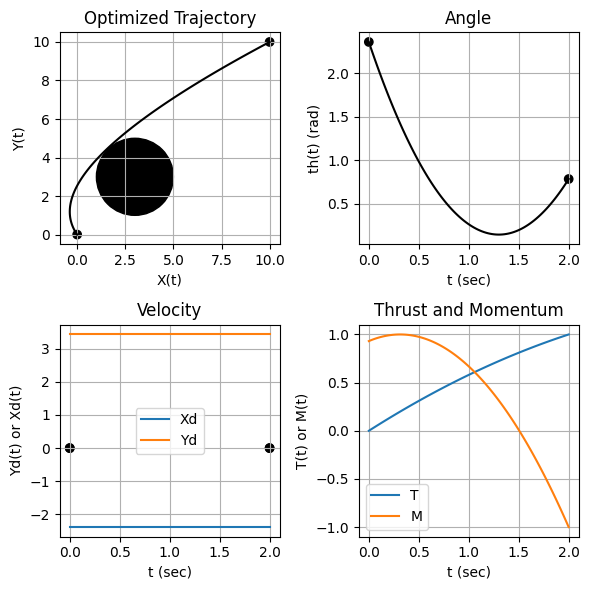

In [ ]:
# plot the trajectory and obstacles
plt.figure(figsize=(6, 6))
plt.subplot(2,2,1); plt.plot(optimized_trajectory[2], optimized_trajectory[4],'k'); plt.grid('on'); plt.xlabel('X(t)'); plt.ylabel('Y(t)'); plt.title('Optimized Trajectory')
plt.scatter([si[2], sf[2]], [si[4], sf[4]], color=['k', 'k'])
for obs in obstacles:
    obstacle = plt.Circle([obs[0], obs[1]], obs[2], color='k', fill=True)
    plt.gca().add_patch(obstacle)

# plot velociy and angle
plt.subplot(2,2,2); plt.plot(time,optimized_trajectory[0],'k'); plt.grid('on');plt.ylabel('th(t) (rad)'); plt.xlabel("t (sec)"); plt.title('Angle')
plt.scatter([time[0], time[-1]], [si[0], sf[0]], color=['k', 'k'])
plt.subplot(2,2,3); plt.plot(time,optimized_trajectory[3], label="Xd"); plt.grid('on');plt.ylabel('Xd(t)'); plt.xlabel("t (sec)"); plt.title('Velocity')
plt.scatter([time[0], time[-1]], [si[3], sf[3]], color=['k', 'k'])
plt.subplot(2,2,3); plt.plot(time,optimized_trajectory[5], label="Yd"); plt.grid('on');plt.ylabel('Yd(t) or Xd(t)'); plt.xlabel("t (sec)")
plt.scatter([time[0], time[-1]], [si[5], sf[5]], color=['k', 'k'])
plt.legend()

# plot thrust and moment
plt.subplot(2,2,4); plt.plot(time,optimized_trajectory[6],label='T'); plt.ylabel("T(t) or M(t)"); plt.grid('on'); plt.title('Thrust and Momentum'); plt.xlabel('t (sec)')
plt.subplot(2,2,4); plt.plot(time,optimized_trajectory[7],label='M'); plt.grid('on');
plt.legend()

# show plot
plt.tight_layout()
plt.show()


# Approach 2
Adapt the code shown in class to solve this specific problem.

Import libraries

In [ ]:
# import the libries
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.constraints import MinMaxNorm
import matplotlib.pyplot as plt

Model the neural network

In [ ]:
# trajectory w no bounds
def createTraj():
    fhat = Sequential()
    fhat.add(Dense(50, activation="sigmoid", input_dim=1))
    fhat.add(Dense(1))
    return fhat

# trajectory w bounded coefficients for thrust
def createThr():
    fhat = Sequential()
    fhat.add(Dense(50, activation="sigmoid", input_dim=1)) #kernel_constraint=MinMaxNorm(min_value=0.0, max_value=1.0, rate=.3, axis=0)))
    fhat.add(Dense(1))
    return fhat

# trajectory w bounded coefficients for moment
def createMom():
    fhat = Sequential()
    fhat.add(Dense(50, activation="sigmoid", input_dim=1)) #kernel_constraint=MinMaxNorm(min_value=-1.0, max_value=1.0, rate=.3, axis=0)))
    fhat.add(Dense(1))
    return fhat

# position tajectory
x = createTraj()
y = createTraj()
th = createTraj()

# velocity trajectory
v = createTraj()
v_th = createTraj()

# control trajectory
moment = createThr()
thrust = createMom()

# number of optimizations for this trajectory
num = 0

Compute the loss function

In [ ]:
# define time scale
t_0, t_f, n_steps = 0., 1., 20
t = tf.cast(tf.linspace(t_0, t_f, n_steps),dtype=tf.float32)

# define loss function
def errors(t):
    # define the state
    with tf.GradientTape(persistent=True) as tape2:
      tape2.watch(t)
      with tf.GradientTape(persistent=True) as tape:
          tape.watch(t)
          # define position
          X = x(t)
          Y = y(t)
          TH = th(t)
      # define velocity
      Xd = tape.gradient(X,t)
      Yd = tape.gradient(Y,t)
      THd = tape.gradient(TH, t)

    # define velocity
    V = v(t)
    V_TH = v_th(t)

    # define acceleration
    Xdd = tape2.gradient(Xd, t)
    Ydd = tape2.gradient(Yd, t)
    THdd = tape2.gradient(THd, t)

    # define control
    M = moment(t)
    T = thrust(t)

    # define initial and final conditions
    x0 = 0; y0 = 0; th0 = 3.14159/4.; v0 = 0; v_th0 = 0
    xf = 10; yf = 10; thf = 3.14159/4.; vf = 0; v_thf = 0

    # define obstacles
    obstacle_radii = [1]          # list of radii
    obstacle_centers = [[5, 5]]    # list of centers in [x, y]
    obstacle_distances = []

    # define obstacles as tf floats
    for i in range(len(obstacle_radii)):
        obstacle_radii[i] = tf.constant(obstacle_radii[i], dtype=tf.float32)
    for i in range(len(obstacle_centers)):
        obstacle_centers[i] = tf.constant(obstacle_centers[i], dtype=tf.float32)

    # define distance between obstacles and trajectory
    for i in range(len(obstacle_radii)):
        distance = tf.sqrt(tf.reduce_sum(tf.square(tf.stack([X, Y], axis=1) - obstacle_centers[i]), axis=1))
        obstacle_distances.append(distance)

    # calculate error in first derivative
    e_Xd = tf.reduce_sum((tf.reshape(Xd,shape=(n_steps,1)) - V*tf.cos(TH))**2)
    e_Yd = tf.reduce_sum((tf.reshape(Yd,shape=(n_steps,1)) - V*tf.sin(TH))**2)
    e_THd = tf.reduce_sum((tf.reshape(THd,shape=(n_steps,1)) - V_TH)**2)

    # calculate error in second derivative
    e_Xdd = tf.reduce_sum((tf.reshape(Xdd,shape=(n_steps,1)) - T*tf.cos(TH))**2)
    e_Ydd = tf.reduce_sum((tf.reshape(Ydd,shape=(n_steps,1)) - T*tf.sin(TH))**2)
    e_THdd = tf.reduce_sum((tf.reshape(THdd,shape=(n_steps,1)) - M)**2)

    # calculate error in initial condition
    e0 = ((X[0] - x0)**2 + (Y[0] - y0)**2  + (TH[0] - th0)**2)
          # + (V[0] - v0)**2 + (V_TH[0] - v_th0)**2)

    # calculate error in final condition
    ef = ((X[-1] - xf)**2 + (Y[-1] - yf)**2 + (TH[-1] - thf)**2)
          # + (V[-1] - vf)**2 + (V_TH[-1] - v_thf)**2)

    # calculate total error
    e_total =  10*e0 + 10*ef + e_Xdd + e_Ydd + e_THdd #+ e_Xd + e_Yd + e_THd

    # calculate penalty for getting close to obstacles
    p_o = 0
    for i in range(len(obstacle_radii)):
        radius = obstacle_radii[i]
        distances = obstacle_distances[i]
        p_o += tf.reduce_sum(tf.nn.relu(radius - distances)**2)

    # caclulate penalty for thrust and moments being out of bounds
    p_T = tf.reduce_sum((max(T) - 1)**2 + (min(T) - 0)**2)
    p_M = tf.reduce_sum((max(M) - 1)**2 + (min(M) + 1)**2)

    # calculate cost
    return e_total + 10000*p_o #+ p_T + p_M



Train the neural network

In [ ]:
# define optimization parameters
n_optimizations = 1   # number of times it does an optimization when cell is run
n_iterations = 3001   # how many times variables are trained per optimization
learning_rate = 0.1   # rate of learning (resolution of learning?)

# number of times of optimizations before running this cell (again)
num0 = num

# optimize the trajectory
while (num - num0) < n_optimizations:
  print("optimization #", num + 1)

  # initialize optimizer
  optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)

  # train the variables for the current optimization
  for i in range(n_iterations):
      # define loss function
      with tf.GradientTape(persistent=True) as tape:
          e = errors(t)

      # print out the current error
      if i%50 == 0:
          print(f'iter: {i}, error: {e}')

      # update parameters in x
      grads = tape.gradient(e, x.trainable_variables)
      optimizer.apply_gradients(zip(grads, x.trainable_variables))

      # update parameters in y
      grads = tape.gradient(e, y.trainable_variables)
      optimizer.apply_gradients(zip(grads, y.trainable_variables))

      # update parameters in th
      grads = tape.gradient(e, th.trainable_variables)
      optimizer.apply_gradients(zip(grads, th.trainable_variables))

      # # update parameters in v
      # grads = tape.gradient(e, v.trainable_variables)
      # optimizer.apply_gradients(zip(grads, v.trainable_variables))

      # # update parameters in v_th
      # grads = tape.gradient(e, v_th.trainable_variables)
      # optimizer.apply_gradients(zip(grads, v_th.trainable_variables))

      # update parameters in thrust
      grads = tape.gradient(e, thrust.trainable_variables)
      optimizer.apply_gradients(zip(grads, thrust.trainable_variables))

      # update parameters in moment
      grads = tape.gradient(e, moment.trainable_variables)
      optimizer.apply_gradients(zip(grads, moment.trainable_variables))

  num += 1
  print()

optimization # 1
iter: 0, error: [699.45154]
iter: 50, error: [2561.8801]
iter: 100, error: [1183.5009]
iter: 150, error: [865.2355]
iter: 200, error: [348.99973]
iter: 250, error: [2160.4685]
iter: 300, error: [1309.3848]
iter: 350, error: [878.0725]
iter: 400, error: [676.18604]
iter: 450, error: [307.0173]
iter: 500, error: [135.53137]
iter: 550, error: [135.22267]
iter: 600, error: [59.56167]
iter: 650, error: [27.982817]
iter: 700, error: [35.037197]
iter: 750, error: [7.80901]
iter: 800, error: [5.936356]
iter: 850, error: [4.415924]
iter: 900, error: [2.973558]
iter: 950, error: [2.4855824]
iter: 1000, error: [7.300746]
iter: 1050, error: [7.8205886]
iter: 1100, error: [1.2975603]
iter: 1150, error: [0.80713356]
iter: 1200, error: [0.57083666]
iter: 1250, error: [0.49639636]
iter: 1300, error: [0.37137774]
iter: 1350, error: [0.5130751]
iter: 1400, error: [1.8231769]
iter: 1450, error: [34.455364]
iter: 1500, error: [1.1355395]
iter: 1550, error: [0.32825524]
iter: 1600, error: 

Plot the trajectory

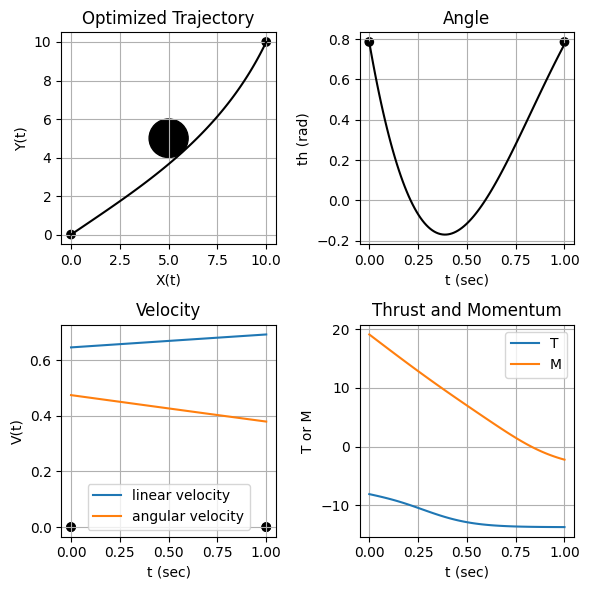

In [ ]:
# define the time scale
n_steps_2 = 100
t_2 = tf.cast(tf.linspace(t_0, t_f, n_steps_2),dtype=tf.float32)
t_2_np = t_2.numpy()

# define the optimized trajectories
with tf.GradientTape(persistent=True) as tape:
    tape.watch(t_2)
    X = x(t_2)
    Y = y(t_2)
    TH = th(t_2)
    V = v(t_2)
    V_TH = v_th(t_2)
    M = moment(t_2)
    T = thrust(t_2)

# redefine initial conditions and obstacles
x0 = 0; y0 = 0; th0 = 3.14159/4.; v0 = 0; v_th0 = 0
xf = 10; yf = 10; thf = 3.14159/4.; vf = 0; v_thf = 0
obstacle_radii = [1]
obstacle_centers = [[5, 5]]

# create plot
plt.figure(figsize=(6, 6))

# plot the trajectory and obstacles
plt.subplot(2,2,1); plt.plot(X.numpy(),Y.numpy(),'k'); plt.grid('on'); plt.xlabel('X(t)'); plt.ylabel('Y(t)'); plt.title('Optimized Trajectory')
plt.scatter([x0, xf], [y0, yf], color=['k', 'k'])
for i in range(len(obstacle_radii)):
  plt.gca().add_patch(plt.Circle(obstacle_centers[i], obstacle_radii[i], color='k', fill=True))

# plot angle
plt.subplot(2,2,2); plt.plot(t_2, TH.numpy(),'k'); plt.grid('on');plt.ylabel('th (rad)'); plt.xlabel("t (sec)"); plt.title('Angle')
plt.scatter([t_0, t_f], [th0, thf], color=['k', 'k'])

# plot velocity
plt.subplot(2,2,3); plt.plot(t_2, V.numpy(), label="linear velocity"); plt.grid('on');plt.ylabel('V(t)'); plt.xlabel("t (sec)"); plt.title('Velocity')
plt.scatter([t_0, t_f], [v0, vf], color=['k', 'k'])
plt.subplot(2,2,3); plt.plot(t_2, V_TH.numpy(), label="angular velocity");
plt.scatter([t_0, t_f], [v_th0, v_thf], color=['k', 'k'])
plt.legend()

# plot thrust and moment
plt.subplot(2,2,4); plt.plot(t_2,T.numpy(),label='T'); plt.ylabel("T or M"); plt.grid('on'); plt.title('Thrust and Momentum'); plt.xlabel('t (sec)')
plt.subplot(2,2,4); plt.plot(t_2,M.numpy(),label='M');
plt.legend()

# show plot
plt.tight_layout()
plt.show()


# Analysis
Describe the solution quality and computational complexity (run times) associated with the different approaches.


I found that approach one (scipy) ran much quicker than the second approach (neural network), as there was no iterations or training to go through. In terms of quality of solution,  my first approach was better than the second, however, I was having issues getting the nueral network to convege when all the constraints were added, with less constraints, the quality of the second solution was better. I would assume that the nueral network solutions typically are better but take longer to run.

Specifically, when solving the solution like how it was in the given example (continuity of only first derivative, no thrust or moments), I found the neural network to work much better in terms of quality of solution, while running slower. I didnt have any issues converging for either approach when solving the problem in the example. Once the second derivative / dynamics continuity came in for this specific assignment, I could not get the solution to convege with all the constraints in either approach. To get the solutions to converge, I first removed continuity of the first derivative. I then removed continuity of velocity initial and final conditions. This allowed for better convergence in both approaches.

For the second approach, whenever I constrained my controls, the tracectory would necome a straight line. I think the issues with convergence in general is that I could just never figure out how to properly constrain the obstacle and thr controls in either approach. I messed with my parameters for hours to try to get a solution for different obstacles. Unfortunately its a very time consuming trial and error with the nature of the runtimes. All that being said, the only constraints I was able to maintain when the second derivative came in was the position and obstacle avoidance (and thrust for the first approach). Like I said, when it was just continuity of position and velocity, I had no issues, but once acceleration came in, the optimization became much more difficult, and I had to remove the velocity constraint when working with the acceleration constraints.

During my problem solving process, I found that I was having troubles finding information online on these modules (tkinter, scipy.optimize, keras, etc), as there would be some examples and info on how functions worked, but it was never quite what I was looking for.

If I had spent more time dedicated to this assignment, I wouldve first tried to get a better understanding these modules and how to apply the theory in class better to these modules. I would also spend more time watching video tutorials, searching the internet more, etc. While I feel I understand the principles of the machine learning and nueral networks, I struggled applying it into code for this assignment with my current skill level and knowledge of these libraries.
